In [72]:
import os
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
data_dir = '/opt/ml/detection/dataset'
anno_source = '/opt/ml/detection/dataset/train.json'

custom_json_dir = '/opt/ml/detection/dataset/candidate'
extension = '.json'
file_name = 'train_vaild_split_sample'

by_image = True
train_vaild_split = True

In [74]:
with open(anno_source) as json_file:
    source_anns = json.load(json_file)

print(source_anns.keys())
source_info = source_anns['info']
source_licenses = source_anns['licenses']
source_images = source_anns['images']
source_categories = source_anns['categories']
source_annotations = source_anns['annotations']

label_name = [ann_dict['name'] for ann_dict in source_categories]
print(f"labels : {label_name}")

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])
labels : ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']


In [75]:
df_images_origin = pd.json_normalize(source_images)
df_images_origin.head()

,width,height,file_name,license,flickr_url,coco_url,date_captured,id
0,1024,1024,train/0000.jpg,0,None,None,2020-12-26 14:44:23,0
1,1024,1024,train/0001.jpg,0,None,None,2021-01-10 16:30:39,1
2,1024,1024,train/0002.jpg,0,None,None,2020-12-27 17:55:52,2
3,1024,1024,train/0003.jpg,0,None,None,2021-03-31 12:10:36,3
4,1024,1024,train/0004.jpg,0,None,None,2021-01-01 18:52:38,4


In [76]:
df_anno_origin = pd.json_normalize(source_annotations)
df_anno_origin.head()

,image_id,category_id,area,bbox,iscrowd,id
0,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
1,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1
2,1,7,26259.36,"[0.0, 455.6, 144.6, 181.6]",0,2
3,1,4,69096.17,"[722.3, 313.4, 274.3, 251.9]",0,3
4,1,5,24164.58,"[353.2, 671.0, 233.7, 103.4]",0,4


In [77]:
df_anno = df_anno_origin.copy()
df_anno[["X","Y","W","H"]] = df_anno['bbox'].tolist()
df_anno.drop(columns='bbox', inplace=True)
df_anno.head()

,image_id,category_id,area,iscrowd,id,X,Y,W,H
0,0,0,257301.66,0,0,197.6,193.7,547.8,469.7
1,1,3,10402.56,0,1,0.0,407.4,57.6,180.6
2,1,7,26259.36,0,2,0.0,455.6,144.6,181.6
3,1,4,69096.17,0,3,722.3,313.4,274.3,251.9
4,1,5,24164.58,0,4,353.2,671.0,233.7,103.4


In [78]:
# df_anno_img_group = df_anno[['image_id','id']].groupby('image_id').agg(pd.Series.count).reset_index()
# query = df_anno_img_group[df_anno_img_group['id']<=5]

# query =  df_anno[df_anno['area'] < 10*10]

# df_anno_origin = df_anno_origin[df_anno_origin['area'] > 1000]
query = df_anno[df_anno['area'] > 1000][['image_id','id']].groupby('image_id').agg(pd.Series.count).reset_index().sample(500)
query.head()
# query의 최종 출력엔 원하는 image_id와, id만 있어도 무방합니다.

,image_id,id
1872,1872,35
1354,1354,3
3944,3944,9
1160,1160,5
2681,2681,1


In [79]:
select_imgs = query['image_id'].unique()
custom_images = df_images_origin[df_images_origin['id'].isin(select_imgs)].to_dict('records')

if by_image:
    df_custom_annos = df_anno_origin[df_anno_origin['image_id'].isin(select_imgs)]
    custom_annos = df_custom_annos.to_dict('records')
else:
    select_annos = query['id'].unique()
    df_custom_annos = df_anno_origin[df_anno_origin['id'].isin(select_annos)]
    custom_annos = df_custom_annos.to_dict('records')


output_info = source_info
output_licenses = source_licenses
output_images = source_images
output_categories = source_categories
output_annotations = source_annotations

output_images = custom_images
output_annotations = custom_annos

custom_json = {
                'info' : output_info, 
                'licenses' : output_licenses, 
                'images' : output_images, 
                'categories' : output_categories, 
                'annotations' : output_annotations
            }

print(f'selected [{len(custom_json["images"])}] images with [{len(custom_json["annotations"])}] annotations')

selected [500] images with [2456] annotations


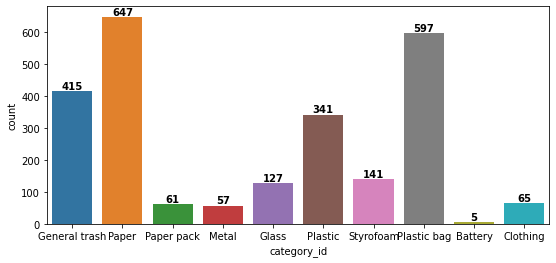

In [80]:
fig, ax = plt.subplots(figsize=(9, 4))
sns.countplot(x='category_id', data=df_custom_annos, ax=ax)
ax.set(xticks=range(len(label_name)), xticklabels=label_name)

for idx, val in df_custom_annos['category_id'].value_counts().sort_index().iteritems():
    ax.text(x=idx, y=val, s=val,
            va='bottom', ha='center',
            fontsize=10, fontweight='semibold'
           )

plt.show()

In [81]:
if train_vaild_split:
    custom_images = df_images_origin[~df_images_origin['id'].isin(select_imgs)].to_dict('records')

    if by_image:
        custom_annos = df_anno_origin[~df_anno_origin['image_id'].isin(select_imgs)].to_dict('records')
    else:
        custom_annos = df_anno_origin[~df_anno_origin['id'].isin(select_annos)].to_dict('records')

    output_images = custom_images
    output_annotations = custom_annos

    train_json = {
                    'info' : output_info, 
                    'licenses' : output_licenses, 
                    'images' : output_images, 
                    'categories' : output_categories, 
                    'annotations' : output_annotations
                }

    print(f'[train] selected [{len(train_json["images"])}] images with [{len(train_json["annotations"])}] annotations')

    valid_path = os.path.join(custom_json_dir, file_name+'_valid'+extension)   
    with open(valid_path, 'w') as outfile:
        json.dump(custom_json, outfile, indent=2)
    print(f"file saved : {valid_path}")

    train_path = os.path.join(custom_json_dir, file_name+'_train'+extension)   
    with open(train_path, 'w') as outfile:
        json.dump(train_json, outfile, indent=2)
    print(f"file saved : {train_path}")

    
else:
    out_path = os.path.join(custom_json_dir, file_name+extension)   
    with open(out_path, 'w') as outfile:
        json.dump(custom_json, outfile, indent=2)
    print(f"file saved : {out_path}")
    

[train] selected [4383] images with [20688] annotations
file saved : /opt/ml/detection/dataset/candidate/train_vaild_split_sample_valid.json
file saved : /opt/ml/detection/dataset/candidate/train_vaild_split_sample_train.json
